# Projects in ML HW 6

## Task 1

We discussed how we can formulate RL problems as an MDP. Describe any
real-world application that can be formulated as an MDP. Describe the state space, action
space, transition model, and rewards for that problem. You do not need to be precise in the
description of the transition model and reward (no formula is needed). Qualitative description
is enough.

One real-world application of MDP I can think of is any type of diasastor control. I think nuclear powerplants are a well known example of such an application. 

The **state space** of a nuclear powerplant can be state of its sensors.

The **action space** of a nuclear poewrplant can be a possible set of actions that can be automated. (i.e. alert operator, stop current action, cooldown mode, etc)

The **transition model** can be composed of the sensor outputs *after* the action is changed. For example, if the coolant is too hot `{...state, coolanttemp: 99}`, the state transition after the action of cooling it down could be into `{...state, coolanttemp: 50}`. Each sensor or group of sensors should have some action linked to it, in the example it is the case of the 'coolant temp sensor' and 'cooling system'.

The **reward** in this case would be minimizing risk, as nuclear powerplants generally produce plenty power, but a single mistake could bring devastating outcome

## Task 2 

RL is used in various sectors - Healthcare, recommender systems and trading
are a few of those. Pick one of the three areas. Explain one of the problems in any of these
domains that can be more effectively solved by reinforcement learning. Find an open-source
project (if any) that has addressed this problem. Explain this project in detail.

Reinforcement learning is well suited to healtcare, as the physician needs to continue monitoring the patient's state and choose the best actions to improve their state. One problem that exists in this domain is that there is often not enough data to sufficiently train a model, due to the sensitive nature of the domain.

I found this open source project from Microsoft called "Med-Deadend" https://github.com/microsoft/med-deadend. 

This project addresses a problem in ML with healthcare -- lack of training data -- and re-scopes the problem so that a good model can be learned with smaller amounts of data. This project focuses on reinforcement learning on data from critically ill patients, and learns to predict a "dead-end", which means the patient will go in critical condition. In essence, the purpose of this model is to identify which procedures must be taken to **prevent** such dead ends. 

The problem is modeled such that a positive outcome gets a reward of 1, and a negative outcome gets a reward of -1. The state space is compoesd of various features of a patient, such as their blodd pressure or hear rate. They also make use of a specific variety of reinforcement learning, called offline reinforcement learning where the learning happens with existing data. Usually, this approach can still take a large amount of data to train sufficiently, but by scoping the problem to a specific domain, the authors show that their model does indeed work. 

Furthur details can also be found in https://www.microsoft.com/en-us/research/blog/using-reinforcement-learning-to-identify-high-risk-states-and-treatments-in-healthcare/


## Task 3

Implement the game of tic-tac-toe (write a class that implements an agent playing Tic Tac Toe and learning its Q function) using the Q-learning technique (see the resources/links provided in class for more details). Clearly describe your evaluation metric and demonstrate a few runs. You might need to use some online resources to proceed on this. Do not forget to cite those.

My main resource for this task was https://github.com/mudasiryounas/tic-tac-toe-game-reinforcement-learning/blob/af7d0b0dda07ddfa43bb5888addf68d0f8af5f43/tic_tac_toe_game.py#L323.

The Q space for each agent is randomly generated. And they are rewarded 1 if they win, 0 if they tie, and -1 if they lose. 

My evalution metric: I am using cumultive reward as my reward function. I record the total amount of updates the agent has to their Q matrix at each update, and use that as performance of the agent/algorithm.

Since in this case I only had the Q algorithm, I don't have anything else to compare with. So I compared the two agents, and as expected the winning agent (player 1) gets more cumultive rewards

In [10]:
# main reference: https://github.com/mudasiryounas/tic-tac-toe-game-reinforcement-learning/blob/af7d0b0dda07ddfa43bb5888addf68d0f8af5f43/tic_tac_toe_game.py#L323

import numpy as np
import pandas as pd
import random
from itertools import product

class Player:
    def __init__(self,id,sym,eps):
        self.sym = sym
        self.id = id
        self.Q = {}
        self.history = []
        self.alpha = .5
        self.eps = .3      
        self.reward_history = []
        self.gamma = .9

    def __str__(self):
        return f'Player {self.id}'

    def __eq__(self,other):
        return self.sym == other.sym and self.id == other.id
    
    def choose_move(self,game):
        best_actions = []
        best_action_value = -999
        possible_actions = game.available_moves()

        if np.random.uniform() < self.eps:
            best_actions = [a for a in possible_actions]
        else:
            for action in possible_actions:
                action_val = self.Q[str(game.board)][action]
                # futureboard = game.get_future_board(self,action)
                if action_val > best_action_value:
                    best_action_value = action_val
                    best_actions = [action]
                elif action_val == best_action_value:
                    best_actions += [action]

        action = random.choice(best_actions)
        # fboard = game.get_future_board(self,action)
        # self.history.append(fboard)
        self.history.append((str(game.board),action,game.get_future_board(self,action)))
        return action

    def update(self,game,move):
        target = game.reward(self,move)
        # self.cum_reward += target
        # print(game)
        # print(move)
        # cum_reward = 0
        for state,action,fboard in self.history[::-1]:
            # print(state)
            self.Q[state][action] += self.alpha * (target +self.gamma * max(self.Q[fboard].values())- self.Q[state][action])
            target = self.Q[state][action]
            # cum_reward += self.Q[state]
        # self.reward_history.append(cum_reward)
        self.history = []
    
class TicTacToe:
    def __init__(self,players,init_players = True):
        self.board = np.zeros((3,3),dtype=int)
        self.actions = list(product(range(3),range(3)))
        self.players = players
        if init_players:
            for p in self.players:
                self.initialize_values(p)
    def reset_board(self):
        self.board = np.zeros((3,3),dtype=int)

    def is_winner(self,player,board = None):
        if type(board) == type(None): board = self.board
        # print(board)
        horizontal = any(map(lambda i: all(board[i] == player.id), range(3))) 
        vertical = any(map(lambda i: all(board[:,i] == player.id), range(3)))
        diag1 = all(board[np.eye(3,dtype=bool)] == player.id)
        diag2 = all(board[np.eye(3,dtype=bool)[::-1]] == player.id)
        return horizontal or vertical or diag1 or diag2

    def is_filled(self,board=None):
        if type(board) == type(None): board = self.board
        return not (board == 0).any()
        # return self.is_winner(self.p1) or self.is_winner(self.p2) or board_filled

    def is_over(self,board=None):
        if type(board) == type(None): board = self.board
        return self.is_filled(board) or any(self.is_winner(p,board) for p in self.players)

    def __str__(self):
        return str(
            pd.DataFrame(
                self.board
            ).replace({
                0:'__',
                **{
                    p.id: p.sym
                    for p in self.players
                }
            })
        )

    def available_moves(self):
        return [a for a in self.actions if self.board[a] == 0]
        # return filter(lambda loc: self.board[loc] == 0,self.actions)

    def reward(self,player,move):
        # print(player)
        # print(move)
        self.board[move] = player.id
        opponent = [p for p in self.players if p != player][0]
        player_won = self.is_winner(player)
        opp_won = self.is_winner(opponent)
        
        reward = 0
        if player_won: reward = 10
        elif opp_won: reward = -1
        # else: return 0

        return reward

    def get_future_board(self,player,action):
        futureboard = self.board.copy()
        futureboard[action] = player.id
        return str(futureboard)

    def initialize_values(self,player):
        player.Q = {
            str(possible_board): {
                a:0
                for a in self.actions
            }
            # 1 if self.is_winner(player,possible_board) else 0 if self.is_over(possible_board) else .5
            for possible_board in map(lambda b: np.array(b).reshape((3,3)),product(*[range(3) for _ in range(9)]))
        }
        # player.Q = {

        # }

    # def pick_best_move(self,player):
    #     for a in self.available_moves():
    #         newboard = self.board.copy()
    #         # newboard[a[]
    


In [11]:

# player 1 is less random. Hopefully they are better!
players = [Player(1,'X',eps=.3),Player(2,'O',eps=.7)]
game = TicTacToe(players)

In [12]:
from tqdm.auto import tqdm

def train(game,players,iter = 100):
    win_counts = np.zeros(len(players))
    for i in tqdm(range(iter)):
        game.reset_board()
        game_over = False
        print(f'===== GAME {i:4d} =====')
        while not game_over:
            for p in players:
                if game_over: break
                move = p.choose_move(game)
                p.update(game,move)

                game_over = game.is_over()

                print(p, '--', move)
                print()
                print(game)
                print()

                if game_over:
                    print('===== GAME OVER =====')
                    wins = [game.is_winner(p) for p in players]
                    if not any(wins):
                        print('draw!')
                        # win_counts[i] += 1
                    else:
                        for i,w in enumerate(wins): 
                            if w: 
                                win_counts[i] += 1
                                print(players[i],'wins!')

                    
                    print('=====================\n')
    return win_counts

train(game,players,100)

  0%|          | 0/100 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

Player 1 -- (2, 1)

    0   1   2
0  __  __  __
1   X  __  __
2   O   X  __

Player 2 -- (0, 0)

   0   1   2
0  O  __  __
1  X  __  __
2  O   X  __

Player 1 -- (1, 2)

   0   1   2
0  O  __  __
1  X  __   X
2  O   X  __

Player 2 -- (0, 1)

   0   1   2
0  O   O  __
1  X  __   X
2  O   X  __

Player 1 -- (2, 2)

   0   1   2
0  O   O  __
1  X  __   X
2  O   X   X

Player 2 -- (1, 1)

   0  1   2
0  O  O  __
1  X  O   X
2  O  X   X

Player 1 -- (0, 2)

   0  1  2
0  O  O  X
1  X  O  X
2  O  X  X

===== GAME OVER =====
Player 1 wins!

===== GAME   18 =====
Player 1 -- (1, 2)

    0   1   2
0  __  __  __
1  __  __   X
2  __  __  __

Player 2 -- (2, 2)

    0   1   2
0  __  __  __
1  __  __   X
2  __  __   O

Player 1 -- (2, 0)

    0   1   2
0  __  __  __
1  __  __   X
2   X  __   O

Player 2 -- (2, 1)

    0   1   2
0  __  __  __
1  __  __   X
2   X   O   O

Player 1 -- (0, 0)

    0   1   2
0   X  __  __
1  __  __   X
2   X   O   O



array([67., 16.])

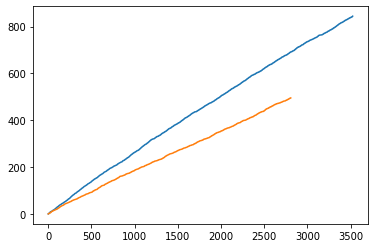

In [ ]:
import seaborn as sns

for i,p in enumerate(players):
    sns.lineplot(
        x = range(len(p.reward_history)),
        y = np.array(p.reward_history).cumsum(),
    )
